<div id="teaser" style=' background-position:  right center; background-size: 00px; background-repeat: no-repeat; 
    padding-top: 20px;
    padding-right: 10px;
    padding-bottom: 170px;
    padding-left: 10px;
    border-bottom: 14px double #333;
    border-top: 14px double #333;' > 

   
   <div style="text-align:center">
    <b><font size="6.4">Compressed sensing for identifying materials descriptors</font></b>    
  </div>
    
<p>
 created by:
 Emre Ahmetcik<sup>1</sup>, 
 Angelo Ziletti<sup>1</sup>,
 Runhai Ouyang<sup> 1</sup>,
 Luca Ghiringhelli<sup> 1</sup>,
 and Matthias Scheffler<sup>1</sup> <br><br>
   
<sup>1</sup> Fritz Haber Institute of the Max Planck Society, Faradayweg 4-6, D-14195 Berlin, Germany <br>
<span class="nomad--last-updated" data-version="v1.0.0">[Last updated: April 5, 2019]</span>
</p>

      
<div> 
<img  style="float: left;" src="data/Logo_MPG.png" width="200"> 
<img  style="float: right;" src="data/Logo_NOMAD.png" width="250">
</div>
</p>

</div>






This tutorial shows how to find descriptive parameters (short formulas) to predict materials properties using compressed sensing tools. As an example, we address the prediction of the zincblende (ZB) versus rocksalt (RS) relative stability of 82 octet binary materials.

The idea of using compressed sensing tools: Starting from simple physical quantities ("building blocks", here properties of the constituent free atoms such as orbital radii), millions (or billions) of candidate formulas are generated by applying arithmetic operations combining building blocks, for example forming sums and products of them. These candidate formulas constitute the so-called "feature space". Then a compressed sensing based method is used to select only a few of these formulas that explain the data, as described in 


<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
L. M. Ghiringhelli, J. Vybiral, S. V. Levchenko, C. Draxl, M. Scheffler: <span style="font-style: italic;">Big Data of Materials Science: Critical Role of the Descriptor</span>,  Phys. Rev. Lett. 114, 105503 (2015) <a href="http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.105503" target="_blank">[PDF]</a>.</div>
In this tutorial we use the Sure Independence Screening and Sparsifying  Operator  (SISSO) as introduced in
<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
R. Ouyang, S. Curtarolo, E. Ahmetcik, M. Scheffler, L. M. Ghiringhelli: <span style="font-style: italic;">SISSO: a compressed-sensing method for identifying the best low-dimensional descriptor in an immensity of offered candidates</span>, Phys. Rev. Materials  2, 083802 (2018) <a href="https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.083802" target="_blank">[PDF]</a> .
</div>

# Introduction to the compressed sensing methods

The feature space is generated by creating a list of analytical expressions (the derived features), obtained by combining <i> primary features </i> and arithmetic operations. In this example, the primary features are properties of isolated atoms, such as electorn affinity or the radial extension of valence orbitals. We put all $m$ derived features into a descriptor matrix $\mathbf{D} \in \mathbb{R}^{82 \times m}$ where each column stands for a derived feature and each row for a compound. An $\ell_0$-regularization 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

determines those few feature columns which approximate a property vector $\mathbf{P} \in \mathbb{R}^{82}$ (i.e RS vs. ZB energy differences) best. The subscript 0 stands for the $\ell_0$-quasinorm, that counts the number of non-zero elements of $\mathbf{c}$ and $\lambda > 0$ is called the regularization parameter. Performing the $\ell_0$-regularization becomes fast computational infeasable and often approximations (i.e. LASSO, orthogonal matching pursuit) are needed since in practice the $\ell_0$-regularization needs to be solved combinatorial: All singletons, pairs, triplets, ... $n$-tuples (up to the selected maximum dimension of the descriptor) are listed and for each set a least-square regression is performed. The $n$-tuple that gives the lowest mean square error for the least-square regression fit is selected as the resulting $n$-dimensional descriptor.

### The LASSO method
A convex optimization problem can be introduced by the Least Absolute Shrinkage and Selection Operator (LASSO):

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Under certain conditions on the matrix $\mathbf{D}$, it can find the exact solution of, or a good approximation to, the $\ell_0$-regularization problem.


### The SISSO method
SISSO works iteratively. In the first iteration, a number $k$ of features is collected that have the largest correlation (scalar product) with $\mathbf{P}$. The feature with the largest correlation is simply the 1D descriptor. Next, a residual is constructed as the error made in the first iteration. A new set of $k$ features is now selected as those having the largest correlation with the residual. The 2D descriptor is the pair of features that yield the smallest fitting error upon least-square regression, among all possible pairs contained in the union of the sets selected in this and the first iteration. In each next iteration a new residual is constructed as the error made in the previous iteration, then a new set of $k$ features is extracted as those that have largest correlation with each new residual. The $n$D descriptor is the $n$-tuple of features that yield the smallest fitting error upon least square regression, among all possible $n$-tuples contained in the union of the sets obtained in each new iteration and all the previous iterations. If $k=1$ the method collapses to the so-called orthogonal matching pursuit.
<img  src="data/SISSO.png" width="800"> 

# Import required modules

In [2]:
import os
import pandas as pd
import numpy as np
from itertools import combinations
from time import time
import matplotlib.pyplot as plt 
from sklearn.linear_model import Lasso
import scipy.stats as ss
import warnings
from collections import Counter
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, LeaveOneOut

from modules.load_data import load_data
from modules.sisso import SissoRegressor
from modules.combine_features import combine_features
from modules.viewer import show_structure, show_map, show_scatter_plot

# set display options for the notebook 
%matplotlib inline
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [3]:
# go to notebook directory, this is needed to run the tutorial
os.chdir(os.getcwd())

# Get the data
Let us load the data from the file data/data.pkl into a data frame. The data was downloaded from the NOMAD archive and the NOMAD atomic data collection. It consists of RS-ZB energy differences (in eV/atom) of the 82 octet binary compounds, structure objects containing the atomic positions of the materials and properties of the atomic constituents. The following atomic features are considered:

<div >
   <ul>
      <li>Z:  atomic number</li>
      <li>period: period in the periodic table</li>
      <li>IP: ionization potential</li>
      <li>EA: electron affinity</li>      
      <li>E_HOMO: energy of the highest occupied atomic orbital</li>
      <li>E_LUMO: energy of the lowest unoccupied atomic orbital</li>   
      <li>r_(s, p, d): radius where the radial distribution of s, p or d orbital has its maximum.</li>
   </ul>
</div>

In [4]:
# load data into pandas data frame
df = load_data()

# print data without structure objects
df.drop(['struc_obj_RS', 'struc_obj_ZB', 'struc_obj_min'], axis=1)

,energy_RS,energy_ZB,energy_diff,min_struc_type,Z(A),Z(B),period(A),period(B),IP(A),IP(B),...,E_HOMO(A),E_HOMO(B),E_LUMO(A),E_LUMO(B),r_s(A),r_s(B),r_p(A),r_p(B),r_d(A),r_d(B)
AgBr,-108781.333959,-108781.303925,-0.030033,RS,47.0,35.0,5.0,4.0,-8.0581,-12.649600,...,-4.710,-8.001,-0.479,0.708,1.32,0.75,1.88,0.88,2.97,1.87
AgCl,-79397.451083,-79397.408285,-0.042797,RS,47.0,17.0,5.0,3.0,-8.0581,-13.901800,...,-4.710,-8.700,-0.479,0.574,1.32,0.68,1.88,0.76,2.97,1.67
AgF,-74477.428165,-74477.274407,-0.153758,RS,47.0,9.0,5.0,2.0,-8.0581,-19.404301,...,-4.710,-11.294,-0.479,1.251,1.32,0.41,1.88,0.37,2.97,1.43
AgI,-171339.208181,-171339.245107,0.036925,ZB,47.0,53.0,5.0,5.0,-8.0581,-11.257100,...,-4.710,-7.236,-0.479,0.213,1.32,0.90,1.88,1.07,2.97,1.72
AlAs,-34200.077513,-34200.290775,0.213262,ZB,13.0,33.0,3.0,4.0,-5.7805,-9.261900,...,-2.784,-5.341,0.695,0.064,1.09,0.85,1.39,1.04,1.94,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SrTe,-137269.487147,-137269.107853,-0.379295,RS,38.0,52.0,5.0,5.0,-6.0316,-9.866700,...,-3.641,-6.109,-1.379,0.099,1.91,0.94,2.55,1.14,1.20,1.83
ZnO,-25540.809205,-25540.911173,0.101968,ZB,30.0,8.0,4.0,2.0,-10.1355,-16.433201,...,-6.217,-9.197,-1.194,2.541,1.10,0.46,1.55,0.43,2.25,2.22
ZnS,-29945.889373,-29946.165186,0.275813,ZB,30.0,16.0,4.0,3.0,-10.1355,-11.795100,...,-6.217,-7.106,-1.194,0.642,1.10,0.74,1.55,0.85,2.25,2.37
ZnSe,-57752.319875,-57752.583012,0.263137,ZB,30.0,34.0,4.0,4.0,-10.1355,-10.946000,...,-6.217,-6.654,-1.194,1.316,1.10,0.80,1.55,0.95,2.25,2.18


In [5]:
df.columns

Index(['energy_RS', 'energy_ZB', 'energy_diff', 'min_struc_type', 'Z(A)',
       'Z(B)', 'period(A)', 'period(B)', 'IP(A)', 'IP(B)', 'EA(A)', 'EA(B)',
       'E_HOMO(A)', 'E_HOMO(B)', 'E_LUMO(A)', 'E_LUMO(B)', 'r_s(A)', 'r_s(B)',
       'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)', 'struc_obj_RS', 'struc_obj_ZB',
       'struc_obj_min'],
      dtype='object')

In [6]:
# demonstrate 3x3x3 supercell of one example structure
example_structure = df.loc['AgBr', 'struc_obj_RS'] * [3, 3, 3]
show_structure(example_structure)

<!DOCTYPE html>
 
 
 <!-- load JSmol; relative path works, absolute fails, might be access rights related -->

Let us look at the distribution of the energy differences.

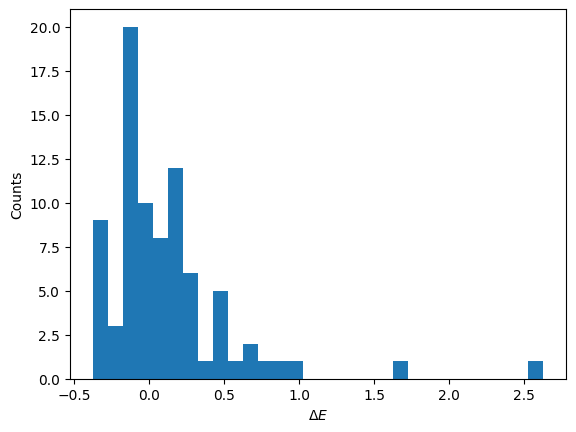

Standard deviation: 0.448 eV/atom


In [7]:
plt.hist(df['energy_diff'].tolist(), bins=30)
plt.xlabel('$\Delta E$')
plt.ylabel('Counts')
plt.show()
print('Standard deviation: %.3f eV/atom' % df['energy_diff'].values.std())

With the SISSO method, we are able to predict the energy differences from the atomic features with an accuracy of 0.035 eV/atom. However, due to computational limit we will target an accuracy of around 0.1 eV/atom in this tutorial.  

Now let us define a function get_data that uses the data frame df_data to define the target vector $\mathbf{P}$ of energy differences and construct the desriptor matrix $\mathbf{D}$ of combined features. The arguments selected_feature_list and allowed_operations specify which primary features and which arithmetic operations should be used to build the new derived features.

使用SISSO方法，我们能够以0.035 eV/atom的准确度从原子特征预测能量差异。然而，由于计算限制，在这个教程中我们将目标准确度设定在大约0.1 eV/atom。

现在让我们定义一个函数get_data，它使用数据框df_data来定义能量差异的目标向量P
P并构建组合特征的描述符矩阵D
D。参数selected_feature_list和allowed_operations指定应使用哪些基本特征和哪些算术运算来构建新的派生特征。

In [8]:
def get_data(selected_feature_list, allowed_operations):
    # add both '(A)', '(B)' to each feature
    selected_featureAB_list = [f+A_or_B for f in selected_feature_list for A_or_B in ['(A)', '(B)']]

    print(selected_featureAB_list)
    
    # extract energy differences and selected features from df_data 
    P = df['energy_diff'].values
    df_features = df[selected_featureAB_list]
    print(df_features)
    
    # derive new features using allowed_operations
    df_combined = combine_features(df=df_features, allowed_operations=allowed_operations)
    return P, df_combined

In [9]:
# selected_feature_list = ['IP', 'EA', 'E_HOMO', 'E_LUMO', 'r_s', 'r_p', 'r_d', 'Z', 'period']
selected_feature_list = ['r_s', 'r_p']

# allowed_operations = ['+', '-', '|-|', '/' '^2', '^3',  'exp']
allowed_operations = ['+']

P, df_D = get_data(selected_feature_list, allowed_operations)

# print derived features
df_D

['r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)']
      r_s(A)  r_s(B)  r_p(A)  r_p(B)
AgBr    1.32    0.75    1.88    0.88
AgCl    1.32    0.68    1.88    0.76
AgF     1.32    0.41    1.88    0.37
AgI     1.32    0.90    1.88    1.07
AlAs    1.09    0.85    1.39    1.04
...      ...     ...     ...     ...
SrTe    1.91    0.94    2.55    1.14
ZnO     1.10    0.46    1.55    0.43
ZnS     1.10    0.74    1.55    0.85
ZnSe    1.10    0.80    1.55    0.95
ZnTe    1.10    0.94    1.55    1.14

[82 rows x 4 columns]
Selected operations:
 ['+']
Number of total features generated: 10


,r_s(A),r_s(B),r_p(A),r_p(B),(r_s(A)+r_s(B)),(r_s(A)+r_p(A)),(r_s(A)+r_p(B)),(r_s(B)+r_p(A)),(r_s(B)+r_p(B)),(r_p(A)+r_p(B))
AgBr,1.32,0.75,1.88,0.88,2.07,3.20,2.20,2.63,1.63,2.76
AgCl,1.32,0.68,1.88,0.76,2.00,3.20,2.08,2.56,1.44,2.64
AgF,1.32,0.41,1.88,0.37,1.73,3.20,1.69,2.29,0.78,2.25
AgI,1.32,0.90,1.88,1.07,2.22,3.20,2.39,2.78,1.97,2.95
AlAs,1.09,0.85,1.39,1.04,1.94,2.48,2.13,2.24,1.89,2.43
...,...,...,...,...,...,...,...,...,...,...
SrTe,1.91,0.94,2.55,1.14,2.85,4.46,3.05,3.49,2.08,3.69
ZnO,1.10,0.46,1.55,0.43,1.56,2.65,1.53,2.01,0.89,1.98
ZnS,1.10,0.74,1.55,0.85,1.84,2.65,1.95,2.29,1.59,2.40
ZnSe,1.10,0.80,1.55,0.95,1.90,2.65,2.05,2.35,1.75,2.50


In [10]:
f = ['r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)']
for i in range(len(f)):
    for j in range(i+1,len(f)):
        print(f[i]+"+"+f[j])
        print(f[i])
        # print(df[f[i]]+df[f[j]])

r_s(A)+r_s(B)
r_s(A)
r_s(A)+r_p(A)
r_s(A)
r_s(A)+r_p(B)
r_s(A)
r_s(B)+r_p(A)
r_s(B)
r_s(B)+r_p(B)
r_s(B)
r_p(A)+r_p(B)
r_p(A)


In [11]:
f[i]

'r_p(B)'

In [12]:
df[f[i]]

AgBr    0.88
AgCl    0.76
AgF     0.37
AgI     1.07
AlAs    1.04
        ... 
SrTe    1.14
ZnO     0.43
ZnS     0.85
ZnSe    0.95
ZnTe    1.14
Name: r_p(B), Length: 82, dtype: float64

In [13]:
df

,energy_RS,energy_ZB,energy_diff,min_struc_type,Z(A),Z(B),period(A),period(B),IP(A),IP(B),...,E_LUMO(B),r_s(A),r_s(B),r_p(A),r_p(B),r_d(A),r_d(B),struc_obj_RS,struc_obj_ZB,struc_obj_min
AgBr,-108781.333959,-108781.303925,-0.030033,RS,47.0,35.0,5.0,4.0,-8.0581,-12.649600,...,0.708,1.32,0.75,1.88,0.88,2.97,1.87,"(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('B...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('B...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('B..."
AgCl,-79397.451083,-79397.408285,-0.042797,RS,47.0,17.0,5.0,3.0,-8.0581,-13.901800,...,0.574,1.32,0.68,1.88,0.76,2.97,1.67,"(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('C...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('C...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('C..."
AgF,-74477.428165,-74477.274407,-0.153758,RS,47.0,9.0,5.0,2.0,-8.0581,-19.404301,...,1.251,1.32,0.41,1.88,0.37,2.97,1.43,"(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('F...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('F...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('F..."
AgI,-171339.208181,-171339.245107,0.036925,ZB,47.0,53.0,5.0,5.0,-8.0581,-11.257100,...,0.213,1.32,0.90,1.88,1.07,2.97,1.72,"(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('I...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('I...","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('I..."
AlAs,-34200.077513,-34200.290775,0.213262,ZB,13.0,33.0,3.0,4.0,-5.7805,-9.261900,...,0.064,1.09,0.85,1.39,1.04,1.94,2.02,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...","(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...","(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SrTe,-137269.487147,-137269.107853,-0.379295,RS,38.0,52.0,5.0,5.0,-6.0316,-9.866700,...,0.099,1.91,0.94,2.55,1.14,1.20,1.83,"(Atom('Sr', [0.0, 0.0, 0.0], index=0), Atom('T...","(Atom('Sr', [0.0, 0.0, 0.0], index=0), Atom('T...","(Atom('Sr', [0.0, 0.0, 0.0], index=0), Atom('T..."
ZnO,-25540.809205,-25540.911173,0.101968,ZB,30.0,8.0,4.0,2.0,-10.1355,-16.433201,...,2.541,1.10,0.46,1.55,0.43,2.25,2.22,"(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('O...","(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('O...","(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('O..."
ZnS,-29945.889373,-29946.165186,0.275813,ZB,30.0,16.0,4.0,3.0,-10.1355,-11.795100,...,0.642,1.10,0.74,1.55,0.85,2.25,2.37,"(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('S...","(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('S...","(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('S..."
ZnSe,-57752.319875,-57752.583012,0.263137,ZB,30.0,34.0,4.0,4.0,-10.1355,-10.946000,...,1.316,1.10,0.80,1.55,0.95,2.25,2.18,"(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('S...","(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('S...","(Atom('Zn', [0.0, 0.0, 0.0], index=0), Atom('S..."


In [14]:
print(P, P.shape)

[-0.03003342 -0.04279728 -0.15375767  0.03692542  0.21326185  0.07294907
  0.21895834  0.15686873  0.27427777  0.87497818  1.71208026  1.01922516
  0.58084911 -0.09299855 -0.31976243 -0.34344513 -0.37538681  0.69183758
  0.50632767  0.49494044  0.46858591  2.62860364 -0.26521904 -0.36913319
 -0.36079773 -0.35045628 -0.08416136  0.0726728   0.08357195  0.11453953
 -0.1558673  -0.15034616 -0.10826332 -0.16238747  0.15244264  0.15625871
 -0.01702227  0.20467458  0.43344524  0.3487518   0.15462529  0.20085253
  0.81144288  0.26321017  0.13404758  0.15372029  0.17919329  0.07805987
 -0.16617596 -0.16446068 -0.1464061  -0.16703915 -0.03274621 -0.03838148
 -0.05948832 -0.02166094 -0.23227472 -0.0866995  -0.0553018  -0.00459129
 -0.12642873 -0.13299199 -0.14578814 -0.11483822 -0.16382053 -0.16050355
 -0.13559578 -0.16720144  0.27916582  0.66902373  0.0169639   0.45353797
  0.08166336  0.1351088  -0.22030662 -0.36843413 -0.37451095 -0.37929473
  0.10196818  0.27581333  0.2631369   0.2450013 ] (

# Determining low-dimensional descriptors with the $\ell_0$ method

<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li> Perform an $\ell_0$-regularization to identify the best low dimensional descriptors using the primary features.</li>
<li> Show that non-linear functions of the primary features improve the models significantly. </li>
<li> See that the $\ell_0$-regularization can rapidly become computational infeasible.</li>
</div>

Our target is to find the best low dimensional descriptor for a linear model $\mathbf{P} = \mathbf{D^\ast}\mathbf{c^\ast}$, where $\mathbf{c^\ast}$ is the vector of nonzero elements of the solution vector $\mathbf{c}$ and $\mathbf{D^\ast}$ is the matrix of the columns of $\mathbf{D}$ corresponding to the nonzero elements of $\mathbf{c}$. The $\ell_0$ regularization

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

provides exactly what we want. It is defined in the following and solved combinatorial:

# 使用 $\ell_0$ 方法确定低维描述符

## 目标

我们的目标是找到线性模型 $\mathbf{P} = \mathbf{D^\ast}\mathbf{c^\ast}$ 的最佳低维描述符，其中 $\mathbf{c^\ast}$ 是解向量 $\mathbf{c}$ 的非零元素组成的向量，而 $\mathbf{D^\ast}$ 是与 $\mathbf{c}$ 的非零元素相对应的矩阵 $\mathbf{D}$ 的列组成的矩阵。

## 方法

我们采用 $\ell_0$ 正则化方法来解决这个问题，其数学表达式为：

$$
\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}
$$

这个表达式的含义是最小化一个由两部分组成的函数：第一部分是数据拟合项 $\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2$，它衡量模型预测 $\mathbf{D}\mathbf{c}$ 与实际数据 $\mathbf{P}$ 之间的差距；第二部分是正则化项 $\lambda \|\mathbf{c}\|_0$，它通过引入参数 $\lambda$ 对解向量 $\mathbf{c}$ 的非零元素的个数进行惩罚，从而鼓励稀疏解，即解向量的多数元素为零。

## 注意事项

- $\ell_0$ 正则化方法可以通过原始特征识别出最佳的低维描述符。
- 通过非线性函数转换原始特征可以显著提高模型的性能。
- 尽管 $\ell_0$ 正则化方法能够有效地找到稀疏解，但它可能会因为计算复杂性而变得不切实际。


In [15]:
def L0(P, D, dimension):
    n_rows, n_columns = D.shape
    D = np.column_stack((D, np.ones(n_rows)))
    SE_min = np.inner(P ,P)
    coef_min, permu_min = None, None
    for permu in combinations(range(n_columns), dimension):
        D_ls = D[:, permu + (-1,)]
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1)
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    RMSE = np.sqrt(SE_min/n_rows)
    return RMSE, coef_min, permu_min

In [16]:
def L0(P, D, dimension):
    # 获取输入矩阵 D 的行数和列数
    n_rows, n_columns = D.shape
    
    # 在 D 的最后一列添加全为 1 的列向量
    D = np.column_stack((D, np.ones(n_rows)))
    
    # 初始化最小平方误差 SE_min 为 P 的内积
    SE_min = np.inner(P ,P)
    
    # 初始化最小系数矩阵 coef_min 和最小排列索引 permu_min 为空
    coef_min, permu_min = None, None
    
    # 遍历所有可能的列组合，其数量为 n_columns 中选 dimension 的组合数
    for permu in combinations(range(n_columns), dimension):
        # 从 D 中选择对应的列，并将结果存储在 D_ls 中
        D_ls = D[:, permu + (-1,)]
        
        # 使用 numpy 的 np.linalg.lstsq 函数对 D_ls 和 P 进行最小二乘求解
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1)
        
        # 如果当前残差平方和 SE 小于之前的最小值 SE_min，则更新 SE_min、coef_min 和 permu_min
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    
    # 计算最小均方根误差 RMSE
    RMSE = np.sqrt(SE_min/n_rows)
    
    # 返回 RMSE、coef_min 和 permu_min
    return RMSE, coef_min, permu_min

In [60]:
for i in combinations(range(4), 2):
    print(i)
    print(i+(-1,))

(0, 1)
(0, 1, -1)
(0, 2)
(0, 2, -1)
(0, 3)
(0, 3, -1)
(1, 2)
(1, 2, -1)
(1, 3)
(1, 3, -1)
(2, 3)
(2, 3, -1)


Perform the $\ell_0$-regularization for different dimensions (numbers of non-zero coefficients in the model) and see the root mean square errors (RMSE) and the selected features.

In [18]:
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = []

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

print("     RMSE   Best desriptor")
for dim in range(1,11):
    RMSE, coefficients, selected_indices = L0(P,D,dim)
    print('%2sD: %.5f' % (dim, RMSE), [features_list[i] for i in selected_indices])

['r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)', 'EA(A)', 'EA(B)', 'IP(A)', 'IP(B)']
      r_s(A)  r_s(B)  r_p(A)  r_p(B)  r_d(A)  r_d(B)   EA(A)   EA(B)    IP(A)  \
AgBr    1.32    0.75    1.88    0.88    2.97    1.87 -1.6666 -3.7393  -8.0581   
AgCl    1.32    0.68    1.88    0.76    2.97    1.67 -1.6666 -3.9708  -8.0581   
AgF     1.32    0.41    1.88    0.37    2.97    1.43 -1.6666 -4.2735  -8.0581   
AgI     1.32    0.90    1.88    1.07    2.97    1.72 -1.6666 -3.5135  -8.0581   
AlAs    1.09    0.85    1.39    1.04    1.94    2.02 -0.3125 -1.8392  -5.7805   
...      ...     ...     ...     ...     ...     ...     ...     ...      ...   
SrTe    1.91    0.94    2.55    1.14    1.20    1.83  0.3431 -2.6660  -6.0316   
ZnO     1.10    0.46    1.55    0.43    2.25    2.22  1.0807 -3.0059 -10.1355   
ZnS     1.10    0.74    1.55    0.85    2.25    2.37  1.0807 -2.8449 -10.1355   
ZnSe    1.10    0.80    1.55    0.95    2.25    2.18  1.0807 -2.7510 -10.1355   
ZnTe    1.10

The result of performing the $\ell_0$-regularization shows that the accuracy converges fast, e.g. we could leave out some components in the linear model without descreasing the accuracy. The second observation is that a linear model of the atomic features is not enough to describe the RS-ZB energy differences. A way out could be using non-linear machine learning models, e.g. kernel ridge regression or a neural network, instead of linear regression. Another way is to put the non-linearity into the descriptors by building algebraic combinations of the atomic features and mapping the few best of these more complex features onto the target again with a linear model. 

Run the following script to build larger feature spaces of more complex features and select the best 1D, 2D and 3D desriptor for a linear model using $\ell_0$-regularization. Plot the results afterwards. How does the accuracy of the models change? How does the feature space size and the dimension of the descriptors depend on the needed time to solve the $\ell_0$-problem?

执行 -regularization 的结果表明，准确度迅速收敛，例如我们可以在线性模型中省略一些成分而不降低准确度。第二个观察是，原子特征的线性模型不足以描述RS-ZB能量差异。一个解决方法可能是使用非线性机器学习模型，例如核岭回归或神经网络，而不是线性回归。另一个方法是将非线性引入描述符中，通过构建原子特征的代数组合，并使用线性模型将少数最佳复杂特征映射到目标上。

运行以下脚本，构建更复杂特征的更大特征空间，并使用 -regularization 为线性模型选择最佳的1D、2D和3D描述符。之后绘制结果。模型的准确度如何变化？特征空间大小和描述符的维度与解决 -问题所需的时间有何关系？

In [19]:
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
op_lists = [[], ['+','|-|'], ['+','|-|','exp'], ['+','|-|','exp', '^2'] ]
X  = []
Errors, Time = np.empty([3,len(op_lists)]), np.empty([3,len(op_lists)])

for n_op, allowed_operations in enumerate(op_lists):
    P, df_D = get_data(selected_feature_list, allowed_operations)
    features_list = df_D.columns.tolist()
    D = df_D.values
    
    number_of_features = len(features_list)
    X.append(number_of_features)
    for dim in range(1,4):
        t1= time()
        RMSE, coefficients, selected_indices = L0(P,D,dim)
        t2 = time()-t1             
        
        Time [dim-1][n_op] = t2
        Errors[dim-1][n_op] = RMSE 
        
        print("n_features: %s; %sD  RMSE: %.3f  best features: %s" 
              %(len(features_list), dim, RMSE, [features_list[i] for i in selected_indices]))

['r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)', 'EA(A)', 'EA(B)', 'IP(A)', 'IP(B)']
      r_s(A)  r_s(B)  r_p(A)  r_p(B)  r_d(A)  r_d(B)   EA(A)   EA(B)    IP(A)  \
AgBr    1.32    0.75    1.88    0.88    2.97    1.87 -1.6666 -3.7393  -8.0581   
AgCl    1.32    0.68    1.88    0.76    2.97    1.67 -1.6666 -3.9708  -8.0581   
AgF     1.32    0.41    1.88    0.37    2.97    1.43 -1.6666 -4.2735  -8.0581   
AgI     1.32    0.90    1.88    1.07    2.97    1.72 -1.6666 -3.5135  -8.0581   
AlAs    1.09    0.85    1.39    1.04    1.94    2.02 -0.3125 -1.8392  -5.7805   
...      ...     ...     ...     ...     ...     ...     ...     ...      ...   
SrTe    1.91    0.94    2.55    1.14    1.20    1.83  0.3431 -2.6660  -6.0316   
ZnO     1.10    0.46    1.55    0.43    2.25    2.22  1.0807 -3.0059 -10.1355   
ZnS     1.10    0.74    1.55    0.85    2.25    2.37  1.0807 -2.8449 -10.1355   
ZnSe    1.10    0.80    1.55    0.95    2.25    2.18  1.0807 -2.7510 -10.1355   
ZnTe    1.10

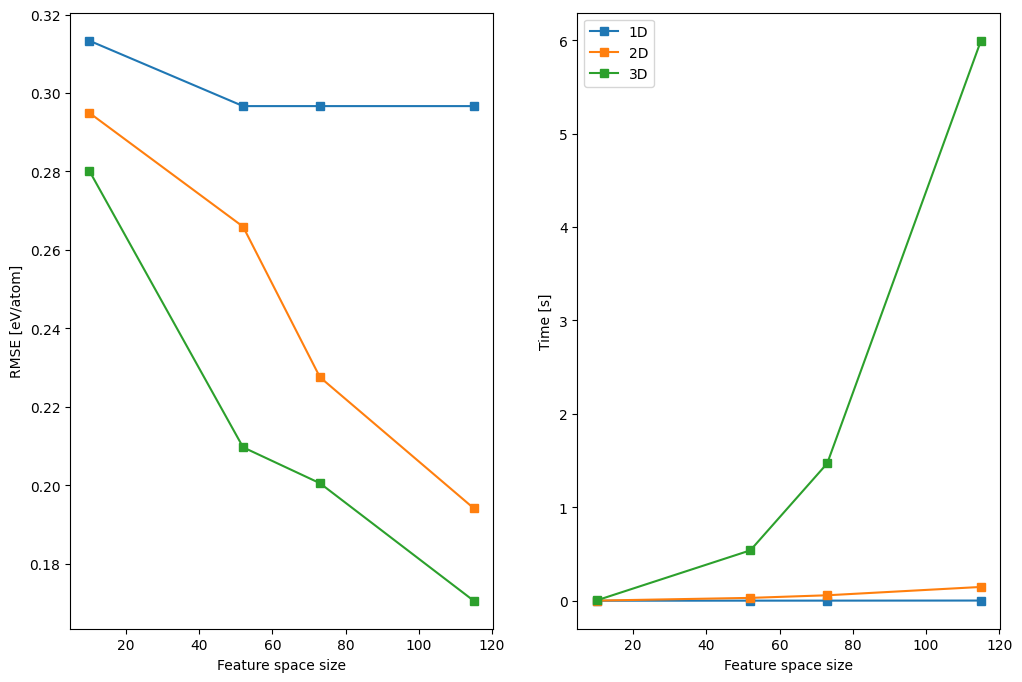

In [20]:
#plot
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(12,8))
ax1.set_xlabel('Feature space size')
ax2.set_xlabel('Feature space size')
ax1.set_ylabel('RMSE [eV/atom]')
ax2.set_ylabel('Time [s]')
#ax2.set_yscale('log')

for dim in range(1,4):
    ax1.plot(X, Errors[dim-1], 's-', label='%sD' %dim)
    ax2.plot(X, Time[dim-1], 's-', label='%sD' %dim)
ax2.legend(loc='best')
plt.show()

Assume now that we would like to include thousands or millions of (more) complex features to obtain more accurate models...

# Approximations to the $\ell_0$ method
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li >Perform a LASSO minimization and the SISSO method.</li>
<li >Compare the solutions with the ones from the $\ell_0$ method.</li>
</div>

### The LASSO


One state-of-the art approximation to the $\ell_0$ method is the LASSO: 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Before performing the LASSO regression we standardize the data to have mean 0 and variance 1, since otherwise the $\ell_2$-norm of a column would affect bias its contribution to the model. <br>
Note that we can use the LASSO also only for feature selection. We use then a least-square model with the selected features afterwards instead of the LASSO model directly.

# $\ell_0$方法的近似

## LASSO最小化

LASSO是最先进的$\ell_0$方法近似之一，其公式为：

$$
\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 + \lambda \|\mathbf{c}\|_1\}
$$

在执行LASSO回归之前，我们需要对数据进行标准化处理，使其均值为0，方差为1。这样做是为了防止列的$\ell_2$-范数影响其对模型的贡献。需要注意的是，LASSO也可以仅用于特征选择，然后使用所选特征进行最小二乘模型拟合，而不是直接使用LASSO模型。

## SISSO方法

我们还将执行SISSO方法，并与$\ell_0$方法的解进行比较。

# LASSO和SISSO方法：ℓ0方法的近似

LASSO（Least Absolute Shrinkage and Selection Operator）和SISSO（Sure Independence Screening and Sparsity Oblivious Learning）方法是解决与ℓ0方法相同问题的先进近似方法，即从原始特征中识别出重要的特征。这些方法采用不同的正则化策略，使得问题更加易于计算。

## LASSO方法

LASSO是ℓ0方法的一种先进近似，其数学表达式为：

$$
\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 + \lambda \|\mathbf{c}\|_1\}
$$

LASSO方法通过在目标函数中添加ℓ1正则化项λ∥c∥1来实现稀疏性，这里的λ是一个超参数，控制着正则化的强度。与ℓ0正则化不同，ℓ1正则化使得问题变得凸，因此可以使用高效的算法来求解。

在执行LASSO回归之前，需要对数据进行标准化处理，使其具有0均值和单位方差。这样做是因为如果不进行标准化，列的ℓ2-范数会影响其对模型的贡献，导致偏差。

LASSO不仅可以作为一个模型，还可以作为一个特征选择工具。在这种情况下，我们使用LASSO来选择特征，然后使用所选特征进行最小二乘模型拟合，而不是直接使用LASSO模型。

## SISSO方法

SISSO方法也将被执行，并与ℓ0方法的解进行比较。



In [21]:
def lasso_fit(lam, P, D, feature_list):
    #LASSO
    D_standardized = ss.zscore(D)
    lasso =  Lasso(alpha=lam)
    lasso.fit(D_standardized, P)
    coef =  lasso.coef_
    
    # get strings of selected features
    selected_indices = coef.nonzero()[0]
    selected_features = [feature_list[i] for i in selected_indices]
    
    # get RMSE of LASSO model
    P_predict = lasso.predict(D_standardized)
    RMSE_LASSO = np.linalg.norm(P-P_predict) / np.sqrt(82.)

    #get RMSE for least-square fit
    D_new = D[:, selected_indices]
    D_new = np.column_stack((D_new, np.ones(82)))
    RMSE_LS = np.sqrt(np.linalg.lstsq(D_new, P, rcond=-1)[1][0]/82.)
        
    return RMSE_LASSO, RMSE_LS, coef, selected_features

$\lambda$ regulates the sparsity of the coefficient vector of the model. Get the data and try different $\lambda$ by adjusting the varibale lam. How good does LASSO (directly or with a least-square fit afterwards) approximate the L0-method (when the same feature space is used for both)?

λ调节模型系数向量的稀疏性。获取数据，通过调整变量lam尝试不同的λ。LASSO（直接或之后用最小二乘拟合）在相同的特征空间下对L0方法的近似效果如何？

In [22]:
#import Data
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = ['+','|-|','exp', '^2']
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

['r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)', 'EA(A)', 'EA(B)', 'IP(A)', 'IP(B)']
      r_s(A)  r_s(B)  r_p(A)  r_p(B)  r_d(A)  r_d(B)   EA(A)   EA(B)    IP(A)  \
AgBr    1.32    0.75    1.88    0.88    2.97    1.87 -1.6666 -3.7393  -8.0581   
AgCl    1.32    0.68    1.88    0.76    2.97    1.67 -1.6666 -3.9708  -8.0581   
AgF     1.32    0.41    1.88    0.37    2.97    1.43 -1.6666 -4.2735  -8.0581   
AgI     1.32    0.90    1.88    1.07    2.97    1.72 -1.6666 -3.5135  -8.0581   
AlAs    1.09    0.85    1.39    1.04    1.94    2.02 -0.3125 -1.8392  -5.7805   
...      ...     ...     ...     ...     ...     ...     ...     ...      ...   
SrTe    1.91    0.94    2.55    1.14    1.20    1.83  0.3431 -2.6660  -6.0316   
ZnO     1.10    0.46    1.55    0.43    2.25    2.22  1.0807 -3.0059 -10.1355   
ZnS     1.10    0.74    1.55    0.85    2.25    2.37  1.0807 -2.8449 -10.1355   
ZnSe    1.10    0.80    1.55    0.95    2.25    2.18  1.0807 -2.7510 -10.1355   
ZnTe    1.10

In [23]:
# features_list

In [24]:
len(features_list)

115

lambda: 0.200	 dimension of descriptor: 2	 RMSE_LASSO: 0.357	 RMSE_LS: 0.291
          features  abs(nonzero_coefs_LASSO)
0  (r_p(A)+r_p(B))                  0.017879
1  (r_p(A)+r_d(B))                  0.119307


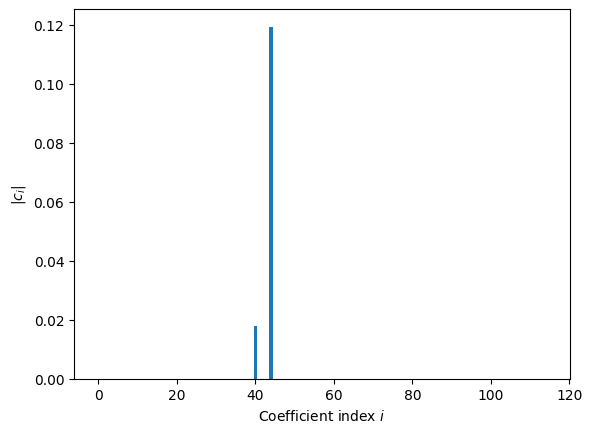

In [25]:
# change lam between 0.02 and 0.34, e.g. 0.34, 0.30, 0.20, 0.13, 0.10, 0.02
lam = 0.2

RMSE_LASSO, RMSE_LS, coef, selected_features = lasso_fit(lam, P, D, features_list)
plt.bar(range(len(coef)), np.abs(coef))
plt.xlabel("Coefficient index $i$")
plt.ylabel("$|c_i|$")

print("lambda: %.3f\t dimension of descriptor: %s\t RMSE_LASSO: %.3f\t RMSE_LS: %.3f" 
      %(lam, len(selected_features), RMSE_LASSO, RMSE_LS))
print(pd.DataFrame({'features':np.array(selected_features), 'abs(nonzero_coefs_LASSO)': np.abs(coef[coef.nonzero()])}))
plt.show()    

In [26]:
lam

0.2

In [27]:
features_list

['EA(A)',
 'EA(B)',
 'IP(A)',
 'IP(B)',
 'r_s(A)',
 'r_s(B)',
 'r_p(A)',
 'r_p(B)',
 'r_d(A)',
 'r_d(B)',
 '(EA(A)+EA(B))',
 '|EA(A)-EA(B)|',
 '(EA(A)+IP(A))',
 '|EA(A)-IP(A)|',
 '(EA(A)+IP(B))',
 '|EA(A)-IP(B)|',
 '(EA(B)+IP(A))',
 '|EA(B)-IP(A)|',
 '(EA(B)+IP(B))',
 '|EA(B)-IP(B)|',
 '(IP(A)+IP(B))',
 '|IP(A)-IP(B)|',
 '(r_s(A)+r_s(B))',
 '|r_s(A)-r_s(B)|',
 '(r_s(A)+r_p(A))',
 '|r_s(A)-r_p(A)|',
 '(r_s(A)+r_p(B))',
 '|r_s(A)-r_p(B)|',
 '(r_s(A)+r_d(A))',
 '|r_s(A)-r_d(A)|',
 '(r_s(A)+r_d(B))',
 '|r_s(A)-r_d(B)|',
 '(r_s(B)+r_p(A))',
 '|r_s(B)-r_p(A)|',
 '(r_s(B)+r_p(B))',
 '|r_s(B)-r_p(B)|',
 '(r_s(B)+r_d(A))',
 '|r_s(B)-r_d(A)|',
 '(r_s(B)+r_d(B))',
 '|r_s(B)-r_d(B)|',
 '(r_p(A)+r_p(B))',
 '|r_p(A)-r_p(B)|',
 '(r_p(A)+r_d(A))',
 '|r_p(A)-r_d(A)|',
 '(r_p(A)+r_d(B))',
 '|r_p(A)-r_d(B)|',
 '(r_p(B)+r_d(A))',
 '|r_p(B)-r_d(A)|',
 '(r_p(B)+r_d(B))',
 '|r_p(B)-r_d(B)|',
 '(r_d(A)+r_d(B))',
 '|r_d(A)-r_d(B)|',
 'r_s(A)^2',
 'r_s(B)^2',
 'r_p(A)^2',
 'r_p(B)^2',
 'r_d(A)^2',
 'r_d(B)^2',


Hint:
Compare these results to the L0 results you have obtained before from the same feature space, copied and pasted in here:<br>
"Number of total features generated: 115 <br>
features: 115; 1D  RMSE: 0.296667841349  best features: ['(r_p(A)+r_d(B))'] <br>
features: 115; 2D  RMSE: 0.194137970112  best features: ['(r_s(B)+r_p(A))', '(r_s(B)+r_p(A))^2'] <br>
features: 115; 3D  RMSE: 0.170545592998  best features: ['(r_s(B)+r_p(A))', '(r_s(B)+r_p(A))^2', 'exp(r_s(B)+r_p(A))']"

### The SISSO method

In [28]:
#import Data
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = ['+','|-|','exp', '^2']
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

['r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)', 'EA(A)', 'EA(B)', 'IP(A)', 'IP(B)']
      r_s(A)  r_s(B)  r_p(A)  r_p(B)  r_d(A)  r_d(B)   EA(A)   EA(B)    IP(A)  \
AgBr    1.32    0.75    1.88    0.88    2.97    1.87 -1.6666 -3.7393  -8.0581   
AgCl    1.32    0.68    1.88    0.76    2.97    1.67 -1.6666 -3.9708  -8.0581   
AgF     1.32    0.41    1.88    0.37    2.97    1.43 -1.6666 -4.2735  -8.0581   
AgI     1.32    0.90    1.88    1.07    2.97    1.72 -1.6666 -3.5135  -8.0581   
AlAs    1.09    0.85    1.39    1.04    1.94    2.02 -0.3125 -1.8392  -5.7805   
...      ...     ...     ...     ...     ...     ...     ...     ...      ...   
SrTe    1.91    0.94    2.55    1.14    1.20    1.83  0.3431 -2.6660  -6.0316   
ZnO     1.10    0.46    1.55    0.43    2.25    2.22  1.0807 -3.0059 -10.1355   
ZnS     1.10    0.74    1.55    0.85    2.25    2.37  1.0807 -2.8449 -10.1355   
ZnSe    1.10    0.80    1.55    0.95    2.25    2.18  1.0807 -2.7510 -10.1355   
ZnTe    1.10

Now apply the SISSO algorithm. How does the SISSO method compare to the LASSO and to the $\ell_0$-regularization in terms of accuracy (again when using the same feature space)? How fast is SISSO compared to the $\ell_0$-regularization? How does n_features_per_sis_iter (the number of features collected per sis iteration) affect the performance? Note, that for n_features_per_sis_iter=1 SISSO becomes the so-called orthogonal matching pursuit, another well-known compressed sensing method.

现在应用SISSO算法。在使用相同的特征空间的情况下，SISSO方法与LASSO和ℓ0正则化相比，在准确性方面表现如何？与ℓ0正则化相比，SISSO的速度有多快？n_features_per_sis_iter（每次sis迭代收集的特征数量）如何影响性能？请注意，当n_features_per_sis_iter=1时，SISSO成为所谓的正交匹配追踪（orthogonal matching pursuit），这是另一种众所周知的压缩感知方法。

In [29]:
sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=10)

sisso.fit(D, P)
sisso.print_models(features_list)

          RMSE            Model
1D:	0.296668	- 0.484 (r_p(A)+r_d(B)) + 1.944
2D:	0.218070	- 3.483 (r_p(A)+r_d(B)) + 0.392 (r_p(A)+r_d(B))^2 + 7.495
3D:	0.193928	- 3.528 (r_p(A)+r_d(B)) + 0.405 (r_p(A)+r_d(B))^2 + 0.293 |r_s(A)-r_d(B)| + 7.280


# Run the SISSO method with a (relatively) big feature space
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Reproduce the results from the <a href="http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.105503" target="_blank">reference publication</a>  by including further features.</li>
<li>Visualize the 2D descriptors in a structure map.</li>
<li>Experiment with different settings and investigate the influence of the input parameters on the results. (OPTIONAL)</li>
</div>
Note the size of the feature space, the needed time to run the code and the accuracy (using the default settings)!

使用相对较大的特征空间运行SISSO方法

通过包含更多特征，复现来自参考出版物《物理评论快报》的结果。
在结构图中可视化2D描述符。
尝试不同的设置，并研究输入参数对结果的影响。（可选）
注意特征空间的大小、运行代码所需的时间以及使用默认设置时的准确性！

In [30]:
# parameters for feature space construction
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = ['+','|-|','exp','^2', '/']

# get the data
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=26)

sisso.fit(D, P)
sisso.print_models(features_list)

['IP(A)', 'IP(B)', 'EA(A)', 'EA(B)', 'r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']
        IP(A)      IP(B)   EA(A)   EA(B)  r_s(A)  r_s(B)  r_p(A)  r_p(B)  \
AgBr  -8.0581 -12.649600 -1.6666 -3.7393    1.32    0.75    1.88    0.88   
AgCl  -8.0581 -13.901800 -1.6666 -3.9708    1.32    0.68    1.88    0.76   
AgF   -8.0581 -19.404301 -1.6666 -4.2735    1.32    0.41    1.88    0.37   
AgI   -8.0581 -11.257100 -1.6666 -3.5135    1.32    0.90    1.88    1.07   
AlAs  -5.7805  -9.261900 -0.3125 -1.8392    1.09    0.85    1.39    1.04   
...       ...        ...     ...     ...     ...     ...     ...     ...   
SrTe  -6.0316  -9.866700  0.3431 -2.6660    1.91    0.94    2.55    1.14   
ZnO  -10.1355 -16.433201  1.0807 -3.0059    1.10    0.46    1.55    0.43   
ZnS  -10.1355 -11.795100  1.0807 -2.8449    1.10    0.74    1.55    0.85   
ZnSe -10.1355 -10.946000  1.0807 -2.7510    1.10    0.80    1.55    0.95   
ZnTe -10.1355  -9.866700  1.0807 -2.6660    1.10    0.94    1.55   

In [31]:
len(features_list)

3391

Next, plot an interactive 2D structure map using the 2D descriptor. By <i>hovering</i> over a point in the plot, information regarding that system is displayed. By <i>clicking</i> a point, an interactive 3D visualization of the structure will be displayed below.

The markers represent the compounds and their colors the reference energy differences. How well does the descriptor separate the compounds with respect to their crystal structure?

In [32]:
# get 2d solution
P_predict = sisso.predict(D, dim=2)
D_selcted = df_D.values[:, sisso.l0_selected_indices[1]]
features = df_D.columns[sisso.l0_selected_indices[1]]

# plot 2D map 
show_map(df, D_selcted, P_predict, features)

<!DOCTYPE html>
 
 
 
 Molecule #0 

 <!-- load JSmol; relative path works, absolute fails, might be access rights related -->
 
 
 

 
 
 
 
 
 
 
 
 
 
 Chemical Formula 
 Structure Type 
 
 
   
 
 
 
 
 
 
 
 
 


 
 
 
 Chemical Formula 
 Structure Type

In [20]:
# !pip install --upgrade bokeh==2.4.3

# Predicting new materials (extrapolation)
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Perform a leave-one-out cross-validation (LOOCV) using SISSO.</li>
<li>Analyze the prediction accuracy and how often the same descriptor is selected.</li>
</div>

We have seen that we can fit the energy differences of materials accurately. But what about predicting the energy difference of a 'new' material (which was not included when determining the model)? We test the prediction performance via LOOCV.  In a LOOCV for each material the following procedure is performed: the selected material is excluded, the model is built on the remaining materials and the model accurcy is tested on the excluded material. This means that we need to run SISSO function 82 times. <br>
Get the data in the next cell and run the LOOCV  one cell after. Note that running the LOOCV  could take up to ten minutes. Use the remaining two cells of this chapter to analyse the results.<br>
How is the prediction error compared to the fitting error? How often is the same descriptor selected? Are there materials that yield an outlying high/low error?

预测新材料（外推法）

使用SISSO执行留一交叉验证（LOOCV）。
分析预测准确性和相同描述符被选中的频率。
我们已经看到我们可以准确地拟合材料的能量差异。但是预测一个“新”材料（在确定模型时没有包括的材料）的能量差异如何呢？我们通过LOOCV测试预测性能。在LOOCV中，对于每种材料执行以下步骤：排除选定的材料，在剩余的材料上建立模型，并在被排除的材料上测试模型准确性。这意味着我们需要运行SISSO函数82次。

在下一个单元格中获取数据，并在接下来的单元格中运行LOOCV。请注意，运行LOOCV可能需要长达十分钟。使用本章的剩余两个单元格来分析结果。

预测误差与拟合误差相比如何？相同描述符被选中的频率是多少？是否有材料的误差异常高/低？

In [33]:
# get the data
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = ['+','|-|','exp', '^2', '/']

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
chemical_formulas = df_D.index.tolist()
D = df_D.values

['IP(A)', 'IP(B)', 'EA(A)', 'EA(B)', 'r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']
        IP(A)      IP(B)   EA(A)   EA(B)  r_s(A)  r_s(B)  r_p(A)  r_p(B)  \
AgBr  -8.0581 -12.649600 -1.6666 -3.7393    1.32    0.75    1.88    0.88   
AgCl  -8.0581 -13.901800 -1.6666 -3.9708    1.32    0.68    1.88    0.76   
AgF   -8.0581 -19.404301 -1.6666 -4.2735    1.32    0.41    1.88    0.37   
AgI   -8.0581 -11.257100 -1.6666 -3.5135    1.32    0.90    1.88    1.07   
AlAs  -5.7805  -9.261900 -0.3125 -1.8392    1.09    0.85    1.39    1.04   
...       ...        ...     ...     ...     ...     ...     ...     ...   
SrTe  -6.0316  -9.866700  0.3431 -2.6660    1.91    0.94    2.55    1.14   
ZnO  -10.1355 -16.433201  1.0807 -3.0059    1.10    0.46    1.55    0.43   
ZnS  -10.1355 -11.795100  1.0807 -2.8449    1.10    0.74    1.55    0.85   
ZnSe -10.1355 -10.946000  1.0807 -2.7510    1.10    0.80    1.55    0.95   
ZnTe -10.1355  -9.866700  1.0807 -2.6660    1.10    0.94    1.55   

In [35]:
# Leave-one-out cross-validation
n_compounds = len(P)
dimensions = range(1, 4)
features_count = [[] for i in range(3)]
P_predict = np.empty([len(dimensions), n_compounds])

sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=10)
loo = LeaveOneOut()

for indices_train, index_test in loo.split(P):
    i_cv = index_test[0]
    print('%2s) Leave out %s: Ediff_ref = %.3f eV/atom' 
          % (index_test[0]+1, chemical_formulas[i_cv], P[i_cv]))
        
    sisso.fit(D[indices_train], P[indices_train])
    sisso.print_models(features_list)    
    
    for dim in dimensions:      
        features = [features_list[i] for i in sisso.l0_selected_indices[dim - 1]]
        predicted_value = sisso.predict(D[index_test], dim=dim)[0]
        
        features_count[dim-1].append( tuple(features) )        
        P_predict[dim-1, i_cv] = predicted_value
        
        print('Ediff_predicted(%sD) = %.3f eV/atom' %(dim, predicted_value))
    print('-----')

 1) Leave out AgBr: Ediff_ref = -0.030 eV/atom
          RMSE            Model
1D:	0.138036	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.332
2D:	0.116855	+ 0.117 |IP(B)-EA(B)|/r_p(A)^2 - 6.691 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.265
3D:	0.084763	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.242 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.391 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.118
Ediff_predicted(1D) = -0.009 eV/atom
Ediff_predicted(2D) = 0.006 eV/atom
Ediff_predicted(3D) = -0.000 eV/atom
-----
 2) Leave out AgCl: Ediff_ref = -0.043 eV/atom
          RMSE            Model
1D:	0.137927	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.332
2D:	0.116617	+ 0.116 |IP(B)-EA(B)|/r_p(A)^2 - 6.711 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.264
3D:	0.084761	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.242 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.388 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.118
Ediff_predicted(1D) = 0.011 eV/atom
Ediff_predicted(2D) = 0.034 eV/atom
Ediff_predicted(3D) = -0.012 eV/atom
-----
 3) Leave out AgF: Ediff_ref = -0.154 eV/atom
          RMSE     

In [36]:
#Plot Prediction errors
%matplotlib inline
prediction_errors = np.linalg.norm(P-P_predict, axis=1)/np.sqrt(n_compounds)
xs = [P] *3
ys = P_predict
legend = ['%sD, RMSE = %.3f eV/atom' %(dim, prediction_errors[dim-1]) for dim in dimensions]
data_point_labels = [df.index.tolist()]*3

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='E_diff_DFT', y_label='E_diff_predicted', legend=legend, unit='eV/atom')

In [37]:
# Print descriptor selection frequency
print("Descriptor selection frequency")
for dim in dimensions:    
    df_frequency = pd.DataFrame( Counter(features_count[dim-1]).most_common(10), columns=['Features', 'Frequency'] )
    print('-----------------\n%sD:\n%s' % (dim, df_frequency))

# create table to display errors and models
feat = np.array(features_count).flatten('F')
Pred = np.array(P_predict).flatten('F')
Pred_errors = np.abs(P-P_predict).flatten('F')
Ref_values = [r for p in P for r in [p,p,p] ]
Mats = [m for mat in chemical_formulas for m in [mat, mat, mat] ]
Dims = ['1D','2D','3D'] * n_compounds

df_loo = pd.DataFrame(zip(Ref_values,Pred,Pred_errors,feat), index = [Mats,Dims],
                  columns=['P_ref[eV]', 'P_pred[eV]', 'abs. error [eV]', 'Selected features'])

#  if you do not want to sort the data frame by the prediction error comment out the nex line 
df_loo = df_loo.sort_values('abs. error [eV]', ascending=False)
pd.set_option('display.expand_frame_repr', False)

display(df_loo)

Descriptor selection frequency
-----------------
1D:
                             Features  Frequency
0           ((IP(A)+IP(B))/r_p(A)^2,)         75
1  ((IP(A)+IP(B))/(r_s(A)+r_p(A))^2,)          3
2           ((IP(B)+EA(A))/r_p(A)^2,)          2
3      (|IP(B)-EA(B)|/exp(r_p(A)^2),)          1
4              (IP(B)/exp(r_p(A)^2),)          1
-----------------
2D:
                                            Features  Frequency
0  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...         60
1  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...         17
2  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/r_s(A...          3
3  ((IP(A)+IP(B))/r_p(A)^2, (r_s(B)+r_d(A))/exp(r...          1
4  (|IP(B)-EA(B)|/exp(r_p(A)^2), r_d(A)/exp(r_d(A...          1
-----------------
3D:
                                            Features  Frequency
0  (|IP(B)-EA(B)|/r_p(A)^2, (r_p(B)+r_d(A))/exp(r...         54
1  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...         11
2  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 82) + inhomogeneous part.

## Kernel ridge regession
It is instructive to compare the performance of the just identified model with a model trained with the popular kernel ridge regression (KRR) approach, by using the same list of atomic features as input. 
KRR solves a $\ell_2$ regularized linear regression problem, with (typically) a nonlinear kernel.
This can be descirbed in the following manner. The $\ell_2$ regularized linear regression problem is:

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_2\}$.

Its solution is:

$\mathbf{c} = \left( \mathbf{D}^\top \mathbf{D} + \lambda \mathbf{I} \right)^{-1} \mathbf{D}^\top \mathbf{P}$

Acoording to Hilbert space representaiton theorem, we can write the solution vector $\mathbf{c}$ as a linear expansion over the data points represented acoording to the chosen descriptor. In other words, $\mathbf{c}$ can be represented as a linear expansion over the rows $\mathbf{d}_j$ of the matrix $\mathbf{D}$.

$\mathbf{c} = \sum_j \alpha_j \mathbf{d}_j $

This rewriting leads to the equivalent problem:

$\text{argmin}_{\boldsymbol{\alpha} \in \mathbb{R}^{N}} \{\|\mathbf{P} - \mathbf{K}\boldsymbol{\alpha}\|^2_2 +\lambda \boldsymbol{\alpha}^\top \mathbf{K} \boldsymbol{\alpha} \} \quad (1)$,

where the kernel $\mathbf{K}$ is: $K_{ij} = < \mathbf{d}_i, \mathbf{d}_j > $.

The rewritten problem has solution $\boldsymbol{\alpha} = \left( \mathbf{K} + \lambda \mathbf{I} \right)^{-1} \mathbf{P} \quad (2)$

This rewriting did not add anything to the regularized linear regression approoach. If, however, we now expand the vector $\mathbf{c}$ as an expansion of nonlinear functions $\Phi()$ of the vectors $\mathbf{d}_j: 

$\mathbf{c} = \sum_j \alpha_j \Phi(\mathbf{d}_j) $

and the kernel as: $K_{ij} = < \Phi(\mathbf{d}_i), \Phi(\mathbf{d}_j)> $, one can prove that the same problem (1) with the same solution (2) holds. Normally, people do not specify the function $\Phi()$, but rahter the kernel.
Actually, $\Phi()$ does not need to be known at all. We refer to the specialized literature on KRR for more details on this method.

Here, we make use of the Gaussian kernel, i.e., the most popular one:

$K(x, y) = \exp(-\gamma ||x-y||^2)$.

The parameters $\lambda$ and $\gamma$ are called <i> hyperparameters </i> and are set via CV. 
Specifically, at each LOOCV step, the hyperparameters ($\ell_2$-regularization parameter $\lambda$ and inverse gaussian width $\gamma$) are optimized via a grid search and a so-called 5-fold cross-validation on the training set. This means splitting the training set in 5 subsets, 1 subset is used for evaluating the performance (RMSE) and the other 4 for training. The procedure is repeated 5 times by changing the test subset and the overall perfrmance is the RMSE over all repetitions. 

What can one observe by comparing the SISSO and KRR results?

In [50]:
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = []

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

['IP(A)', 'IP(B)', 'EA(A)', 'EA(B)', 'r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']
        IP(A)      IP(B)   EA(A)   EA(B)  r_s(A)  r_s(B)  r_p(A)  r_p(B)  \
AgBr  -8.0581 -12.649600 -1.6666 -3.7393    1.32    0.75    1.88    0.88   
AgCl  -8.0581 -13.901800 -1.6666 -3.9708    1.32    0.68    1.88    0.76   
AgF   -8.0581 -19.404301 -1.6666 -4.2735    1.32    0.41    1.88    0.37   
AgI   -8.0581 -11.257100 -1.6666 -3.5135    1.32    0.90    1.88    1.07   
AlAs  -5.7805  -9.261900 -0.3125 -1.8392    1.09    0.85    1.39    1.04   
...       ...        ...     ...     ...     ...     ...     ...     ...   
SrTe  -6.0316  -9.866700  0.3431 -2.6660    1.91    0.94    2.55    1.14   
ZnO  -10.1355 -16.433201  1.0807 -3.0059    1.10    0.46    1.55    0.43   
ZnS  -10.1355 -11.795100  1.0807 -2.8449    1.10    0.74    1.55    0.85   
ZnSe -10.1355 -10.946000  1.0807 -2.7510    1.10    0.80    1.55    0.95   
ZnTe -10.1355  -9.866700  1.0807 -2.6660    1.10    0.94    1.55   

In [51]:
features_list

['IP(A)',
 'IP(B)',
 'EA(A)',
 'EA(B)',
 'r_s(A)',
 'r_s(B)',
 'r_p(A)',
 'r_p(B)',
 'r_d(A)',
 'r_d(B)']

In [52]:
kr = GridSearchCV(KernelRidge(kernel='rbf'), cv=5,
                  param_grid={"alpha": np.logspace(-3, 0, 5),
                              "gamma": np.logspace(-2, 1, 5)})
P_predict_kr = []
loo = LeaveOneOut()
for indices_train, index_test in loo.split(P):
    kr.fit(D[indices_train], P[indices_train])
    print("%2i Ediff_ref: %.3f, Ediff_pred: %.3f, hyperparameters: {'lambda': %.3f, 'gamma':%.3f}" 
          % (index_test[0], P[index_test], kr.predict(D[index_test]), 
          kr.best_params_['alpha'], kr.best_params_['gamma']))
    P_predict_kr.append(kr.predict(D[index_test])[0])


 0 Ediff_ref: -0.030, Ediff_pred: -0.031, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 1 Ediff_ref: -0.043, Ediff_pred: -0.018, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 2 Ediff_ref: -0.154, Ediff_pred: -0.063, hyperparameters: {'lambda': 0.178, 'gamma':0.056}
 3 Ediff_ref: 0.037, Ediff_pred: 0.012, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 4 Ediff_ref: 0.213, Ediff_pred: 0.184, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 5 Ediff_ref: 0.073, Ediff_pred: 0.369, hyperparameters: {'lambda': 0.178, 'gamma':0.056}
 6 Ediff_ref: 0.219, Ediff_pred: 0.215, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 7 Ediff_ref: 0.157, Ediff_pred: 0.127, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 8 Ediff_ref: 0.274, Ediff_pred: 0.245, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 9 Ediff_ref: 0.875, Ediff_pred: 0.803, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
10 Ediff_ref: 1.712, Ediff_pred: 0.836, hyperparameters: {'lambda': 0.032, 'gamma':0.010}
11 E

In [53]:
D.shape

(82, 10)

In [54]:
D.shape

(82, 10)

In [45]:
prediction_rmse_kr = np.linalg.norm(np.array(P_predict_kr) - P)/np.sqrt(P.size)

xs = [P, P]
ys = [P_predict[-1], P_predict_kr,]
legend = ['SISSO 3D, RMSE = %.3f eV/atom' % prediction_errors[dim-1], 
          'KR, RMSE = %.3f eV/atom' % prediction_rmse_kr]
data_point_labels = [df.index.tolist()]*2

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='E_diff_DFT', y_label='E_diff_predicted', legend=legend, unit='eV/atom')

In [55]:
P.shape

(82,)

In [56]:
D.shape

(82, 10)